# Title: GraphML Tests
## Purpose: Explore ML on graphs, networks, etc
## @author: mjz

## Background




## Assumptions

## Setup

We can run boromir with the following command:

`./run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'`

mttf.yml:
```
mttf:
    flags:
        # secmet_score_strategy: 'reliability'
        secmet_plot_intermediate_graphs: False
        secmet_random_cvss_score: True
```

Using the mttf.yml file helps us track runs with version control systems, but all flags can be specified at the command line as well. `--secmet_random_cvss_score=True` and `--boromir_run_count=1000` create 1000 samples with vulnerability scores chosen from a uniform random distribution in `[0.0, 10.0]` to represent a CVSS score. Other distributions and intervals can be defined as well.

The flag `--bigquery_table='cloud-performance-tool:test_notebook_bq.test1'` tells boromir where to publish the results. If no publishing target is specified the results are stored as json in the $TMP directory. Influxdb setup is covered in notebook `000_influxdb_setup.ipynb`.



In [1]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
ds = 'test_notebook_bq'
tab = 'test1'
proj = 'cloud-performance-tool'
tbl1_full = '`cloud-performance-tool.test_notebook_bq.test1`'
key_loc = '/home/toor/.google/smu-benchmarking-7de5dd11902f.json'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
from google.cloud import bigquery
%reload_ext google.cloud.bigquery

import pandas as pd
import pandas_gbq

In [4]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_loc # bq_client needs this (svc_acct auth)
# bigquery_client = bigquery.Client(project=proj) # 

pandas_gbq.context.project = proj
pandas_gbq.context.dialect = 'standard'

In [5]:
%%bigquery
SELECT * FROM `cloud-performance-tool.test_notebook_bq.test1`
where labels != ''
limit 5

,sample_uri,run_uri,owner,official,timestamp,unit,test,product_name,value,labels,metric
0,6b38d42b-fd91-472d-bc60-c1caf57f751f,abeb2a2f,cat-dog,False,1.588019e+09,weeks,mttf,py_mulval,6.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
1,e2fe45f7-d22b-431d-89b6-4180fc6197db,abeb2a2f,cat-dog,False,1.588019e+09,weeks,mttf,py_mulval,8.0,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
2,192e68ac-df72-460c-946a-71b1b716f80b,abeb2a2f,cat-dog,False,1.588019e+09,weeks,mttf,py_mulval,64.5,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
3,58b4683e-d210-4528-95e0-549e8cdff0ed,abeb2a2f,cat-dog,False,1.588019e+09,weeks,mttf,py_mulval,42.5,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf
4,b5d41542-cf95-4eda-ae3c-4b052741ac78,abeb2a2f,cat-dog,False,1.588019e+09,weeks,mttf,py_mulval,85.5,"|attack_graph_reduced:{""directed"": true, ""mult...",mttf


Most of the details we'll need for ML are captured in the metadata field `labels`. 

We can extract the interesting fields into a pandas dataframe as follows:


In [14]:
%%bigquery df

#standardSQL
SELECT thedate, test, value, unit, metric,
-- citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
attack_graph, transition_matrix, transition_matrix_raw,
labels
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels,metric, 
    REGEXP_EXTRACT(labels, r'(?s)\|citation:(.*?)\|') AS citation,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS attack_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix:(.*?)\|') AS transition_matrix,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix_raw:(.*?)\|') AS transition_matrix_raw,
    
  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
     and run_uri = 'abeb2a2f'
     )

In [15]:
df.head()

,thedate,test,value,unit,metric,attack_graph,transition_matrix,transition_matrix_raw,labels
0,2020-04-27 20:28:09.171360+00:00,mttf,6.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [6.1, 0.0, 0....","|attack_graph_reduced:{""directed"": true, ""mult..."
1,2020-04-27 20:28:28.203377+00:00,mttf,8.0,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [5.16, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
2,2020-04-27 20:28:14.036628+00:00,mttf,64.5,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [5.04, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
3,2020-04-27 20:28:43.294453+00:00,mttf,42.5,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.37, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."
4,2020-04-27 20:28:15.703002+00:00,mttf,85.5,weeks,mttf,"{""directed"": true, ""multigraph"": true, ""graph""...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2, 0.0, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.61, 0.0, 0...","|attack_graph_reduced:{""directed"": true, ""mult..."


In [16]:
df[df['metric']=='mttf'].describe()

,value
count,1000.000000
mean,34.735627
std,35.306114
min,0.020592
25%,5.040383
50%,14.043433
75%,55.202178
max,191.833333


In [17]:
df[df['metric']=='mttf'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
thedate                  1000 non-null datetime64[ns, UTC]
test                     1000 non-null object
value                    1000 non-null float64
unit                     1000 non-null object
metric                   1000 non-null object
attack_graph             1000 non-null object
transition_matrix        1000 non-null object
transition_matrix_raw    1000 non-null object
labels                   1000 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 78.1+ KB


We can see how these values fall within our experimental range by fixing the lower and upper bounds of security for this topology with the following configuration (`mttf_step_cvss.yml`):

```
mttf:
    flag_matrix: fmatrix
    flag_matrix_defs:
        fmatrix:
            secmet_fix_cvss_score: [1, 2, 3, 4, 5, 6,  7, 8, 9, 10]
    flags:
        secmet_plot_intermediate_graphs: False
        secmet_map_scores: 'cvss2time'
```

In [18]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf_step_cvss.yml --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

[('3', '1', {'score': 5000.0, 'score_orig': 0.0, 'weight': 5000.0, 'label': 5000.0}), ('5', '3', {'score': 5000.0, 'score_orig': 0.0, 'weight': 5000.0, 'label': 5000.0}), ('8', '5', {'score': 5000.0, 'score_orig': 0.0, 'weight': 5000.0, 'label': 5000.0}), ('13', '5', {'score': 5000.0, 'score_orig': 0.0, 'weight': 5000.0, 'label': 5000.0}), ('13', '8', {'score': 5000.0, 'score_orig': 0.0, 'weight': 5000.0, 'label': 5000.0}), ('0', '13', {'score': 5000.0, 'score_orig': 0.0, 'weight': 5000.0, 'label': 5000.0})]
  (1, 0)	0.0
  (2, 1)	0.0
  (3, 2)	0.0
  (4, 2)	0.0
  (4, 3)	0.0
  (5, 4)	0.0
[('3', '1', {'score': 5000.0, 'score_orig': 1.0, 'weight': 5000.0, 'label': 5000.0}), ('5', '3', {'score': 5000.0, 'score_orig': 1.0, 'weight': 5000.0, 'label': 5000.0}), ('8', '5', {'score': 5000.0, 'score_orig': 1.0, 'weight': 5000.0, 'label': 5000.0}), ('13', '5', {'score': 5000.0, 'score_orig': 1.0, 'weight': 5000.0, 'label': 5000.0}), ('13', '8', {'score': 5000.0, 'score_orig': 1.0, 'weight': 5000.0,

2020-04-27 15:31:40,027 [MainThread  ] [DEBUG] Using publishers: [<BigQueryPublisher table="cloud-performance-tool:test_notebook_bq.test1">, <LogPublisher logger=<RootLogger root (DEBUG)> level=20>, <PrettyPrintStreamPublisher stream=<_io.TextIOWrapper name='<stdout>' mode='w' encoding='UTF-8'>>, <NewlineDelimitedJSONPublisher file_path="/tmp/mulpy/runs/None/py_mulval_results.json" mode="w">]
2020-04-27 15:31:40,027 a3988617 MainThread INFO     Verbose logging to: /tmp/mulpy/runs/None/boromir.log
2020-04-27 15:31:40,028 a3988617 MainThread INFO     PerfKitBenchmarker version: unknown
2020-04-27 15:31:40,028 a3988617 MainThread INFO     Flag values:
--benchmark_config_file=mttf_step_cvss.yml
--bigquery_table=cloud-performance-tool:test_notebook_bq.test1
--benchmarks=mttf
2020-04-27 15:31:40,047 a3988617 MainThread INFO     Setting --max_concurrent_threads=200.
2020-04-27 15:31:40,247 a3988617 MainThread mttf(1/11) INFO     Provisioning resources for benchmark mttf
2020-04-27 15:31:40,26

In [19]:
%%bigquery df_fixed_cvss

#standardSQL
SELECT thedate, test, value, unit, metric,
-- citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
attack_graph, transition_matrix, transition_matrix_raw, fix_cvss_score,
labels
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels,metric, 
    REGEXP_EXTRACT(labels, r'(?s)\|citation:(.*?)\|') AS citation,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS attack_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix:(.*?)\|') AS transition_matrix,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix_raw:(.*?)\|') AS transition_matrix_raw,
    REGEXP_EXTRACT(labels, r'(?s)\|secmet_fix_cvss_score:(.*?)\|') AS fix_cvss_score,
    
  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
     AND run_uri = 'a3988617'
     )

In [20]:
df_fixed_cvss["fix_cvss_score"] = pd.to_numeric(df_fixed_cvss["fix_cvss_score"])
df_fixed_cvss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 10 columns):
thedate                  11 non-null datetime64[ns, UTC]
test                     11 non-null object
value                    11 non-null float64
unit                     11 non-null object
metric                   11 non-null object
attack_graph             11 non-null object
transition_matrix        11 non-null object
transition_matrix_raw    11 non-null object
fix_cvss_score           11 non-null float64
labels                   11 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 1008.0+ bytes


Text(0.5, 1.0, 'Fixed vuln scores in the range 0..10')

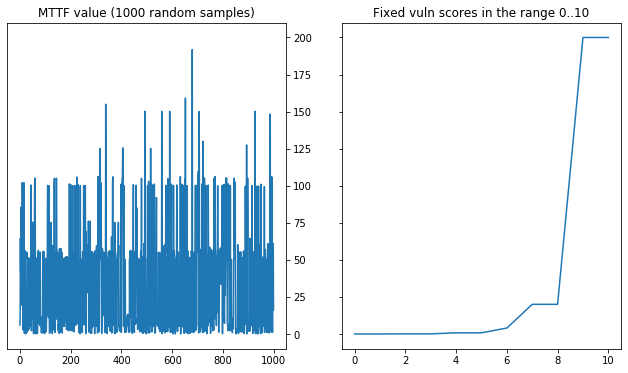

In [82]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11,6))


ax1.plot(df['value'])
ax1.set_title('MTTF value (1000 random samples)')
ax1.yaxis.tick_right()
# ax1.set_yticks([']) 

ax2.plot(df_fixed_cvss['value'])
ax2.set_title('Fixed vuln scores in the range 0..10')


,value
count,1000.000000
mean,34.830997
std,32.985484
min,0.018800
25%,5.371758
50%,31.015150
75%,55.032575
max,175.500000


So out of 1000 samples, our average time to compromise is ~34 weeks. 